## Portfolio Part 3

In this Portfolio task you will continue working with the movielens data collected by the GroupLens Research Project at the University of Minnesota. The columns in the dataset are a little bit different from the ones provided in the previous Portfolio tasks, where the 'rating' column is replaced by the 'feedback' column. There are two values regarding the 'feedback' with 1 indicating the user likes the corresponding movie; otherwise 0. 

The header of the csv file is shown below. 

| userId | age | gender | occupation| movieId | feedback | genre | timestamp |
    | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | 
    
#### Description of Fields

* __userId__ - the user's id
* __age__ - the user's age
* __gender__ - the user's gender
* __occupation__ - the user's occupation
* __movieId__ - the movie's id
* __feedback__ - the user's feedback towards the movie (1 means 'like'; 0 means 'dislike')
* __genre__ - the genre of the movie
* __timestamp__ - the timestamp indicating when the user rated the movie

Note that, a same user (i.e., a same userId) corresponds to a same age/gender/occupation; a same movie (i.e., a same movieId) corresponds to a same genre; a same user (i.e., a same userId) may like multiple movies and a same movie (i.e., a same movieId) may be preferred by multiple users.


Your high level goal in this notebook is to try to build and evaluate predictive models for feedback from available features - predict the value of the __feedback__ field in the data from some of the other fields. Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.

Note: you are not being evaluated on the ___accuracy___ of the model but on the ___process___ that you use to generate it. Please use a ___simple Logistic Regression model___ and ___one of the more advanced methods___ covered in recent weeks. Accordingly, discuss the performance of the simple and advanced methods.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier


import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('files/movielens_data_feedback.csv')
print(df.shape)
df.head(10)

(100000, 8)


,userId,age,gender,occupation,movieId,feedback,genre,timestamp
0,196,49,M,writer,242,0,Comedy,881250949
1,186,39,F,executive,302,0,Crime,891717742
2,22,25,M,writer,377,0,Children,878887116
3,244,28,M,technician,51,0,Romance,880606923
4,166,47,M,educator,346,0,Drama,886397596
5,298,44,M,executive,474,1,War,884182806
6,115,31,M,engineer,265,0,Action,881171488
7,253,26,F,librarian,465,1,Adventure,891628467
8,305,23,M,programmer,451,0,Romance,886324817
9,6,42,M,executive,86,0,Drama,883603013


# Data Exploration

In [4]:
# Use info() to identify the data types and the null of each feature.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   userId      100000 non-null  int64 
 1   age         100000 non-null  int64 
 2   gender      100000 non-null  object
 3   occupation  100000 non-null  object
 4   movieId     100000 non-null  int64 
 5   feedback    100000 non-null  int64 
 6   genre       100000 non-null  object
 7   timestamp   100000 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.1+ MB


In [5]:
# Numerical values that are going to be used in the model.
df_num=df[['age', 'feedback']]

# Categorical values that are going to be used in the model.
df_cat=df[['gender', 'occupation', 'genre', 'feedback']] # Categorical values that are going to be used in the model.

Of the numerical features of the dataset only age is going to be used as a predictor variable. This is due to the fact that age may have a causal factor in the feedback given whereas timestamp, userid and movieid appear to be either arbitrary or random. All of the categorical variables will also be used in the model as they provide valuable information about the individuals giving feedback which may be able to be used to predict the feedback given. 

### Numeric Features

In [6]:
# Quantile Statistics for numeric variables
df_num.describe()

,age,feedback
count,100000.000000,100000.000000
mean,32.969850,0.553750
std,11.562623,0.497105
min,7.000000,0.000000
25%,24.000000,0.000000
50%,30.000000,1.000000
75%,40.000000,1.000000
max,73.000000,1.000000


Mean and Median values of age feature are close in value indicating that there arent any outliers.

Text(0, 0.5, 'Frequancy')

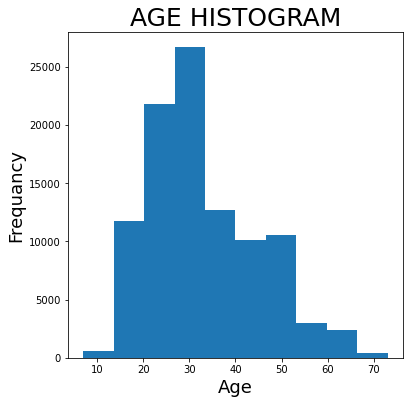

In [7]:
# Distribution of the age feature.
plt.figure(figsize = (6,6))
plt.hist(df_num['age'])
plt.title('AGE HISTOGRAM', size = 25)
plt.xlabel('Age', size = 18)
plt.ylabel('Frequancy', size = 18)

Distribution appears to be normal, further proving the lack of outliers in the variable.

In [8]:
# Average age for the values of feedback.
pd.pivot_table(df_num, index = 'feedback', values = ['age'])

,age
feedback,
0,32.46344
1,33.37795


Average ages for the two feedback values are really close, indicating that age is not a good predictor of feedback.

### Categorical Features

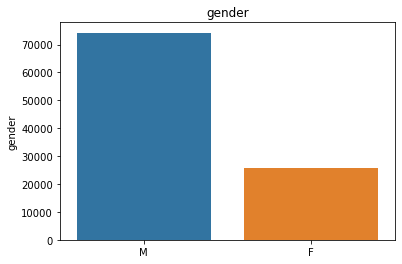

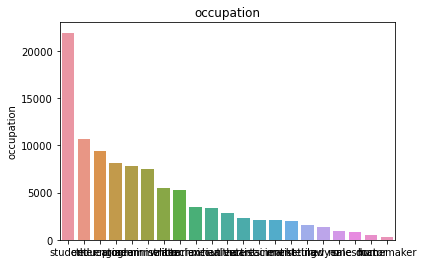

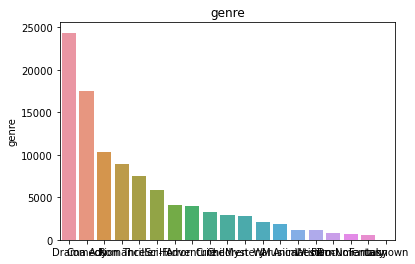

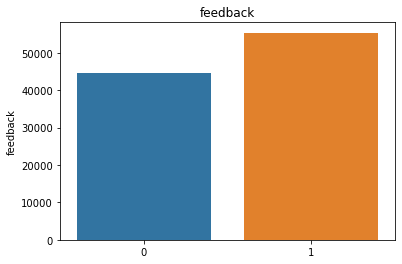

In [9]:
# Barplots of the categorical vaiables to visualize the values counts.
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index,df_cat[i].value_counts()).set_title(i)
    plt.show()

Genre and occupation appear to follow a similar pattern. There is significantly more males than females in this dataset.

In [10]:
# Value counts of occupation.
df_cat.groupby('occupation')['occupation'].count() \
.reset_index(name='count') \
.sort_values(['count'], ascending=False)

,occupation,count
18,student,21957
13,other,10663
3,educator,9442
4,engineer,8175
14,programmer,7801
0,administrator,7479
20,writer,5536
10,librarian,5273
19,technician,3506
6,executive,3403


In [11]:
# Value counts of genre.
df_cat.groupby('genre')['genre'].count() \
.reset_index(name='count') \
.sort_values(['count'], ascending=False)

,genre,count
7,Drama,24378
4,Comedy,17536
0,Action,10356
13,Romance,8883
15,Thriller,7553
14,Sci-Fi,5902
10,Horror,4120
1,Adventure,4013
5,Crime,3303
3,Children,2900


In [12]:
# Value counts of gender.
df_cat.groupby('gender')['gender'].count() \
.reset_index(name='count') \
.sort_values(['count'], ascending=False)

,gender,count
1,M,74260
0,F,25740


In [13]:
# Value counts of feedback.
df_cat.groupby('feedback')['feedback'].count() \
.reset_index(name='count') \
.sort_values(['count'], ascending=False)

,feedback,count
1,1,55375
0,0,44625


Positive feedback is the most frequant result with 55.375% of the reviews.

# Data Preprocessing For Model

In [14]:
df.head()

,userId,age,gender,occupation,movieId,feedback,genre,timestamp
0,196,49,M,writer,242,0,Comedy,881250949
1,186,39,F,executive,302,0,Crime,891717742
2,22,25,M,writer,377,0,Children,878887116
3,244,28,M,technician,51,0,Romance,880606923
4,166,47,M,educator,346,0,Drama,886397596


In [15]:
# Create secound dataframe with only features that will be involved in the model.
df_model = df[['feedback', 'age', 'gender', 'genre', 'occupation']]
df_model.head() 

,feedback,age,gender,genre,occupation
0,0,49,M,Comedy,writer
1,0,39,F,Crime,executive
2,0,25,M,Children,writer
3,0,28,M,Romance,technician
4,0,47,M,Drama,educator


In [16]:
# Use an ordinal encoder on the gender column to create a numeric variable which indicates
# whether the feedback is given by a male or not.
ord_enc = OrdinalEncoder()
df_model['male'] = ord_enc.fit_transform(df_model[['gender']])
df_model.drop('gender', axis=1, inplace=True)
df_model.head()

,feedback,age,genre,occupation,male
0,0,49,Comedy,writer,1.0
1,0,39,Crime,executive,0.0
2,0,25,Children,writer,1.0
3,0,28,Romance,technician,1.0
4,0,47,Drama,educator,1.0


In [17]:
# Use get_dummies to create dummy variables for the two categorical features with more than 2 values.
df_model = pd.get_dummies(df_model, columns=['genre', 'occupation'])
df_model.head()

,feedback,age,male,genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,0,49,1.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,39,0.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,25,1.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,28,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,47,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Split the data into training(80%) and testing data (20%) and use random_state=142.
train, test = train_test_split(df_model, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(80000, 43)
(20000, 43)


In [19]:
# Include the required features for each data set that will be used in the model.
X_train = train.drop(['feedback'], axis=1)
y_train = train['feedback']
X_test = test.drop(['feedback'], axis=1)
y_test = test['feedback']

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (80000, 42)
y_train shape:  (80000,)
X_test shape:  (20000, 42)
y_test shape:  (20000,)


The dataset must be prepared to under go modeling and evaluation. Firstly, all the features that were selected earlier during the data exploration were grouped together into one data set. Then the  categorical features were encoded into numeric features in order for the model to be able to use them. The gender feature was encoded with an ordinal encoder since it only requires one column that states whether the user is male or not, if not than it is assumed that the user is female. The remaining two categorical features have multiple categories and therefore a one hot encoder was used to create a variable for each of the categories. Finally the data was split into training and testing datasets where 80% of the dataset was used to train the model and 20% of the dataset was used for testing.     

# Build and Evaluate Logistic Regression Model

In [20]:
# Instansiate and fit the Logistic Regression model to the training data sets.
model_basic = LogisticRegression()
model_basic.fit(X_train, y_train)

LogisticRegression()

In [21]:
# Use the model to make a prediction using both the X_train and X_test data sets.
y_hat_train = model_basic.predict(X_train)
y_hat_test = model_basic.predict(X_test)

In [22]:
# Evaluate the performance of the trained model.
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_test))

Accuracy score on training set:  0.578175
Accuracy score on testing set:  0.579


In [23]:
# Confusion Matrix of Training set.
print("Confusion matrix on train set: ")
print(confusion_matrix(y_train, y_hat_train))

Confusion matrix on train set: 
[[12311 23470]
 [10276 33943]]


In [24]:
# Confusion Matrix of Test set.
print("Confusion matrix on test set: ")
print(confusion_matrix(y_test, y_hat_test))

Confusion matrix on test set: 
[[2964 5880]
 [2540 8616]]


The Logistic Regression model returns an accuaracy score of 0.578 on the training set and and also 0.579 on the testing set. The training and testing accuracy scores are relatively close which tells us that there is no overfitting of the model. The testing set had an accuracy score of 57.9% is only 2.525% greater than the proportion of values that were positive in the feedback variable, which was 55.375% positive. This indicates that the model was not able to preform very well. 

# Feature Selection

In [236]:
# Accuaracy score for model for each number of features.
acc_scores = []
for i in range(1,42):
    clf = LogisticRegression()
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # training model
    rfe.fit(X_train, y_train)
    # predicting on test set
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    print("Acc on test set using", i, "features: ", acc_score)
    # append to the list
    acc_scores.append(acc_score)

Acc on test set using 1 features:  0.5661
Acc on test set using 2 features:  0.56895
Acc on test set using 3 features:  0.57435
Acc on test set using 4 features:  0.57455
Acc on test set using 5 features:  0.57445
Acc on test set using 6 features:  0.57435
Acc on test set using 7 features:  0.57435
Acc on test set using 8 features:  0.57435
Acc on test set using 9 features:  0.57435
Acc on test set using 10 features:  0.5753
Acc on test set using 11 features:  0.5761
Acc on test set using 12 features:  0.57595
Acc on test set using 13 features:  0.5762
Acc on test set using 14 features:  0.57725
Acc on test set using 15 features:  0.57735
Acc on test set using 16 features:  0.5776
Acc on test set using 17 features:  0.57755
Acc on test set using 18 features:  0.57755
Acc on test set using 19 features:  0.5769
Acc on test set using 20 features:  0.57755
Acc on test set using 21 features:  0.57805
Acc on test set using 22 features:  0.57705
Acc on test set using 23 features:  0.57705
Acc

In [25]:
# Creating RFE object for Logistic regression model with optimal number of features.
lr_model = LogisticRegression()
rfe2 = RFE(estimator=lr_model, n_features_to_select=41, step=1)
rfe2.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=41)

In [26]:
# Evaluating accuaracy for model with optimal number of features.
y_test_hat = rfe2.predict(X_test)
print("accuracy score on test set: ", accuracy_score(y_test, y_test_hat))

accuracy score on test set:  0.58


In [27]:
# Summarize all features.
for i in range(X_train.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (X_train.columns[i], rfe2.support_[i], rfe2.ranking_[i]))

Column: age, Selected True, Rank: 1.000
Column: male, Selected True, Rank: 1.000
Column: genre_Action, Selected True, Rank: 1.000
Column: genre_Adventure, Selected True, Rank: 1.000
Column: genre_Animation, Selected True, Rank: 1.000
Column: genre_Children, Selected True, Rank: 1.000
Column: genre_Comedy, Selected True, Rank: 1.000
Column: genre_Crime, Selected True, Rank: 1.000
Column: genre_Documentary, Selected True, Rank: 1.000
Column: genre_Drama, Selected True, Rank: 1.000
Column: genre_Fantasy, Selected True, Rank: 1.000
Column: genre_Film-Noir, Selected True, Rank: 1.000
Column: genre_Horror, Selected True, Rank: 1.000
Column: genre_Musical, Selected True, Rank: 1.000
Column: genre_Mystery, Selected True, Rank: 1.000
Column: genre_Romance, Selected True, Rank: 1.000
Column: genre_Sci-Fi, Selected True, Rank: 1.000
Column: genre_Thriller, Selected True, Rank: 1.000
Column: genre_War, Selected True, Rank: 1.000
Column: genre_Western, Selected True, Rank: 1.000
Column: genre_unkno

# Logistic Regression With Feature Selection

In [28]:
# Training set of predictor variables after features selection.
X_trainRFE = X_train[X_train.columns[rfe2.support_]]
X_trainRFE

,age,male,genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
36772,51,1.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43891,46,1.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52044,29,1.0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
14810,60,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
64521,37,0.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5146,48,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40204,21,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
78335,28,1.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
31131,50,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
# Testing set of predictor variables after features selection.
X_testRFE = X_test[X_test.columns[rfe2.support_]]
X_testRFE

,age,male,genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
34418,48,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19159,41,1.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
68995,45,0.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
39368,18,1.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
21641,20,1.0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64004,45,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84971,29,1.0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
62359,32,1.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
45709,27,0.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [30]:
# Instansiate and fit the Logistic Regression model to the training data sets after feature selection.
model_RFE = LogisticRegression()
model_RFE.fit(X_trainRFE, y_train)

LogisticRegression()

In [31]:
# Use the model to make a prediction using both the X_trainRFE and X_testRFE data sets.
y_hat_trainRFE = model_RFE.predict(X_trainRFE)
y_hat_testRFE = model_RFE.predict(X_testRFE)

In [32]:
# Evaluate the performance of the trained model.
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_trainRFE))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_testRFE))

Accuracy score on training set:  0.5791
Accuracy score on testing set:  0.58


In [33]:
# Confusion Matrix of Training set after feature selection.
print("Confusion matrix on train set: ")
print(confusion_matrix(y_train, y_hat_trainRFE))

Confusion matrix on train set: 
[[12173 23608]
 [10064 34155]]


In [34]:
# Confusion Matrix of Test set after feature selection.
print("Confusion matrix on test set: ")
print(confusion_matrix(y_test, y_hat_testRFE))

Confusion matrix on test set: 
[[2928 5916]
 [2484 8672]]


In [35]:
# Comparasin of accuracy scores between models with and without RFE feature selection.
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_test))
print("Accuracy score on testing set after feature selection: ", accuracy_score(y_test, y_hat_testRFE))

Accuracy score on testing set:  0.579
Accuracy score on testing set after feature selection:  0.58


Recurive Feature Elimination was used to find which features provide the most acurate results. The most acurate model had an accuracy score of 58%, which was an improvement of the original model by 0.1% and it used 41 of the 42 avaliable features. The feature genre_unknown was left out of this model. The feature elimintion was only slighlty impactful in improving the model.

# Build and Evaluate KNN Classifier 

In [47]:
# Instansiate and fit the KNN model to the training data sets.
knn_basic = KNeighborsClassifier(n_neighbors=81)
knn_basic.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=81)

In [48]:
# Use the model to make a prediction using both the X_train and X_test data sets.
y_hat_trainKNN = knn_basic.predict(X_train)
y_hat_testKNN = knn_basic.predict(X_test)

In [49]:
# Evaluate the performance of the trained model.
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_trainKNN))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_testKNN))

Accuracy score on training set:  0.6242125
Accuracy score on testing set:  0.6108


# KNN Model Tuning

In [45]:
from sklearn.model_selection import GridSearchCV
parameter_grid = {'n_neighbors': range(1, 135, 5)}
knn_clf = KNeighborsClassifier()
gs_knn = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True))
gs_knn.fit(X_train, y_train)

print('Best K value: ', gs_knn.best_params_['n_neighbors'])
print('The accuracy: %.4f\n' % gs_knn.best_score_)

Best K value:  81
The accuracy: 0.6090



The Grid Search CV found the optimal amount of neighbors for the KNN model to predict feedback, with 81.  

# Conclusion

The KNN model preformed better than the Logistic Regression model by 3.08%. 